In [1]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

In [2]:
DIR = '/mnt/poseidon/remotesensing/arctic/data/training/testData_unmixingRegression/'
FILE = 'harmonicFitted_ndvi_monthlyComposite_purePFT.csv'
PATH = DIR + FILE

# 1. Get NDVI timeseries for points

In [3]:
harmonic_orig = pd.read_csv(PATH)

In [4]:
pft = harmonic_orig[['PFT']]

In [5]:
harmonic_orig.columns

Index(['system:index', '2019_02_fitted', '2019_03_fitted', '2019_04_fitted',
       '2019_05_fitted', '2019_06_fitted', '2019_07_fitted', '2019_08_fitted',
       '2019_09_fitted', '2019_10_fitted', '2020_02_fitted', '2020_03_fitted',
       '2020_04_fitted', '2020_05_fitted', '2020_06_fitted', '2020_07_fitted',
       '2020_08_fitted', '2020_09_fitted', '2020_10_fitted', 'PFT', 'SAMPLE_1',
       'SAMPLE_2', 'SAMPLE_3', 'SAMPLE_4', 'SAMPLE_5', 'SAMPLE_6', 'SAMPLE_7',
       'id', 'layer', 'path', 'xcoord', 'ycoord', '.geo'],
      dtype='object')

In [6]:
harmonic = harmonic_orig.filter(regex='_fitted')

In [7]:
# set datetime objects and rescale NDVI
harmonic.columns = pd.to_datetime(harmonic.columns, format='%Y_%m_fitted')
harmonic = harmonic * .0001
harmonic

,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01
0,-0.207764,-0.174199,-0.240158,-0.141903,0.221584,0.470413,0.347843,0.081222,-0.040183,-0.231545,-0.199246,-0.264974,-0.157122,0.210313,0.448702,0.315436,0.050754,-0.065998
1,-0.240207,-0.198655,-0.273980,-0.125243,0.231577,0.438824,0.394829,0.218763,-0.067788,-0.268257,-0.229087,-0.301952,-0.143384,0.214313,0.412978,0.362533,0.183417,-0.107978
2,-0.236024,-0.171712,-0.272695,-0.143734,0.210902,0.412820,0.378557,0.241552,-0.035308,-0.264574,-0.202897,-0.302183,-0.162609,0.193051,0.386338,0.346689,0.206911,-0.076915
3,-0.237294,-0.180241,-0.273498,-0.145648,0.198773,0.404896,0.389247,0.261949,-0.014756,-0.267290,-0.212762,-0.304220,-0.166267,0.179288,0.377452,0.356490,0.225920,-0.057735
4,-0.183791,-0.150792,-0.205617,-0.132499,0.189814,0.430795,0.319849,0.054223,-0.050961,-0.204145,-0.171915,-0.227156,-0.145700,0.181074,0.412814,0.291092,0.027222,-0.072100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,-0.133673,-0.096835,-0.176695,-0.086696,0.185567,0.312580,0.198312,0.045776,-0.067779,-0.147102,-0.112262,-0.191135,-0.092836,0.180229,0.298689,0.179316,0.028503,-0.085809
90,-0.145108,-0.100440,-0.216404,-0.120859,0.154035,0.295203,0.276156,0.185723,-0.079643,-0.163353,-0.121969,-0.236106,-0.131380,0.143691,0.278226,0.256114,0.162413,-0.111003
91,-0.147860,-0.106717,-0.223143,-0.121167,0.155795,0.296846,0.285997,0.200388,-0.081339,-0.166832,-0.129130,-0.243416,-0.132227,0.144682,0.279259,0.265570,0.176172,-0.114276
92,-0.174801,-0.104376,-0.246353,-0.114783,0.206134,0.314506,0.260842,0.206353,-0.073406,-0.194935,-0.128557,-0.267975,-0.125109,0.194077,0.293766,0.239145,0.182399,-0.109549


In [8]:
# check for inverse curves
july = harmonic[['2019-07-01']]
pftjuly = pd.concat([july, pft], axis=1)
pftjuly.rename(columns = {pftjuly.columns[0]: 'July NDVI'}, inplace=True)

In [9]:
pfts = pftjuly['PFT'].unique()

[Text(0.5, 1.0, 'July NDVI spread of monthly harmonic timeseries')]

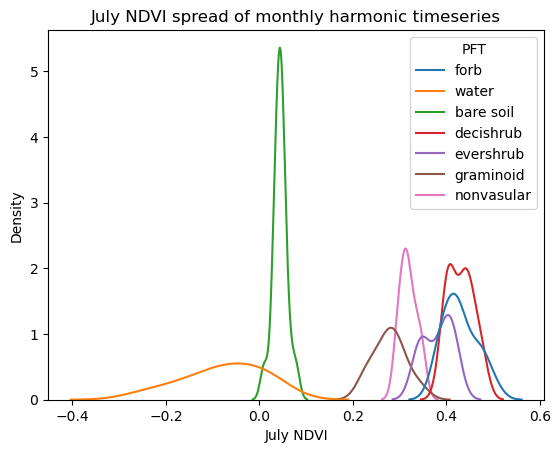

In [10]:
import seaborn as sns
sns.kdeplot(x=pftjuly['July NDVI'], 
            hue=pftjuly['PFT']).set(title='July NDVI spread of monthly harmonic timeseries')

# 2. Orusa et al method

a moving average window with a mean radius of 10 days was realized every 20 days. In cases where a pixel in the 20-day composite window was empty because of a lack of valid observations, the window size was increased to 40 days. Afterwards, a cubic spline interpolation to convert the 20-day composites to a daily time series was applied.
- DataFrame.rolling(window, min_periods=None, center=False, win_type=None, on=None, axis=0).mean()

## 2.1. Moving average and cubic spline

In [54]:
def function1(timeseries, dates):

    steplist = np.arange(1, len(timeseries)-2, 1).tolist()

    def function(ii):

        p0, d0 = timeseries[ii-1], dates[ii-1] # ndvi/date at index 0
        p1, d1 = timeseries[ii], dates[ii]     # ndvi/date at index 1
        p2, d2 = timeseries[ii+1], dates[ii+1] # ndvi/date at index 2
        p3, d3 = timeseries[ii+2], dates[ii+2] # ndvi/date at index 3

        # difference in days between dates
        diff01 = (d1 - d0).astype('timedelta64[D]') #in days
        diff01 = int(diff01 / np.timedelta64(1, 'D'))
        diff12 = (d2 - d1).astype('timedelta64[D]') #in days
        diff12 = int(diff12 / np.timedelta64(1, 'D'))
        diff23 = (d3 - d2).astype('timedelta64[D]') #in days
        diff23 = int(diff23 / np.timedelta64(1, 'D'))

        # normalize days
        diff01nor = diff01 / diff12 # 1 - 0 / 2 - 1
        diff12nor = diff12 / diff12 # 2 - 1 / 2 - 1
        diff23nor = diff23 / diff12 # 3 - 2 / 2 - 1

        # prep vars
        f0 = p1
        f1 = p2
        f0p = (p2 - p0) / (diff01nor + diff12nor) # ndvi 2 - ndvi 0 / days
        f1p = (p3 - p1) / (diff12nor + diff23nor) # ndvi 3 - ndvi 1 / days

        # spline vars
        a = (f0*2) - (f1*2) + f0p + f1p
        b = (f0*-3) + (f1*3) - (f0p*2) - f1p
        c = f0p
        d = f0

        # create spline function
        xValues = np.arange(0, diff12-1, 1) # daily step
        xDates = pd.date_range(d1, d2, freq='D') # daily step
        # xValues = np.arange(0, (diff12-1)*24, 1) # hourly step
        # xDates = pd.date_range(d1, d2, freq='H')
        
        def daily_spline(x): 
            val = x / diff12
            return ((val**3) * a) + ((val**2) * b) + (val*c) + d, xDates[x]

        interpolated = []
        interpolated_dates = []
        # apply spline            
        for x in xValues:
            interp, date = daily_spline(x)
            interpolated.append(interp)
            interpolated_dates.append(date)

        return interpolated, interpolated_dates
    
    interp = []
    interp_dates = []
    for step in steplist:
        i, d = function(step) # list of interp images
        interp.append(i)
        interp_dates.append(d)
        
    def flatten(l):
        return [item for sublist in l for item in sublist]
        
    return flatten(interp), flatten(interp_dates)

In [55]:
# apply moving window (smoothing) and cubic spline (daily interpolation)
dates = harmonic.columns.to_numpy()
splined = harmonic.apply(lambda row: function1(row, dates), axis=1, result_type='expand')

In [14]:
# add dates as columns
splined_2019 = pd.DataFrame(splined[0].tolist(), index=harmonic.index)
splined_2019.columns = splined[1].tolist()[0]
splined_2019 = splined_2019.filter(regex='2019')

In [15]:
splined_2019

,2019-03-01,2019-03-02,2019-03-03,2019-03-04,2019-03-05,2019-03-06,2019-03-07,2019-03-08,2019-03-09,2019-03-10,...,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31
0,-0.174199,-0.174932,-0.176013,-0.177416,-0.179115,-0.181083,-0.183294,-0.185722,-0.188339,-0.191120,...,-0.181489,-0.182877,-0.184258,-0.185630,-0.186994,-0.188350,-0.189697,-0.191036,-0.192367,-0.193689
1,-0.198655,-0.199459,-0.200702,-0.202351,-0.204371,-0.206729,-0.209389,-0.212317,-0.215479,-0.218841,...,-0.225948,-0.227056,-0.228155,-0.229245,-0.230327,-0.231401,-0.232468,-0.233529,-0.234582,-0.235630
2,-0.171712,-0.172617,-0.174062,-0.176008,-0.178415,-0.181242,-0.184452,-0.188003,-0.191856,-0.195973,...,-0.215184,-0.216560,-0.217924,-0.219277,-0.220618,-0.221947,-0.223266,-0.224574,-0.225871,-0.227158
3,-0.180241,-0.181118,-0.182497,-0.184342,-0.186615,-0.189278,-0.192294,-0.195627,-0.199238,-0.203091,...,-0.209597,-0.211175,-0.212742,-0.214296,-0.215840,-0.217372,-0.218893,-0.220404,-0.221904,-0.223394
4,-0.150792,-0.151315,-0.152131,-0.153217,-0.154552,-0.156115,-0.157883,-0.159835,-0.161950,-0.164205,...,-0.165316,-0.166410,-0.167496,-0.168576,-0.169648,-0.170712,-0.171770,-0.172820,-0.173863,-0.174898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,-0.096835,-0.097767,-0.099085,-0.100762,-0.102768,-0.105074,-0.107653,-0.110474,-0.113511,-0.116733,...,-0.132690,-0.133126,-0.133558,-0.133983,-0.134403,-0.134818,-0.135228,-0.135633,-0.136032,-0.136427
90,-0.100440,-0.101915,-0.103900,-0.106357,-0.109250,-0.112541,-0.116192,-0.120168,-0.124431,-0.128944,...,-0.157363,-0.157507,-0.157645,-0.157777,-0.157904,-0.158026,-0.158144,-0.158259,-0.158370,-0.158478
91,-0.106717,-0.108260,-0.110313,-0.112838,-0.115797,-0.119154,-0.122870,-0.126909,-0.131232,-0.135803,...,-0.160806,-0.160930,-0.161048,-0.161161,-0.161269,-0.161373,-0.161474,-0.161571,-0.161666,-0.161760
92,-0.104376,-0.105940,-0.108174,-0.111031,-0.114460,-0.118415,-0.122845,-0.127704,-0.132941,-0.138509,...,-0.180713,-0.181151,-0.181579,-0.181998,-0.182408,-0.182810,-0.183203,-0.183588,-0.183967,-0.184338


In [16]:
# get data from specified time period
def select_period(data, sdate, edate):
    transposed = data.T
    transposed.index.name = 'timestamp'
    query = f'timestamp.between("{sdate}", "{edate}")'
    result = transposed.query(query)
    result = result.T
    return result

In [17]:
harmonic_aprnov = select_period(harmonic, "2019-04-01", "2019-10-31")

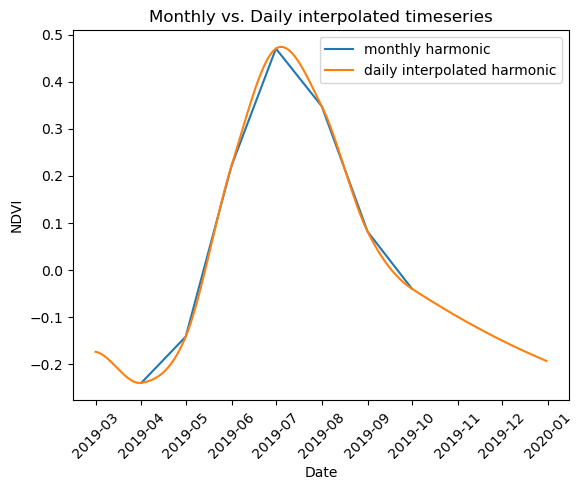

In [18]:
# plot dataframes
plt.plot(harmonic_aprnov.iloc[0], label='monthly harmonic')
plt.plot(splined_2019.iloc[0], label='daily interpolated harmonic')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('Monthly vs. Daily interpolated timeseries')
plt.legend()
plt.show()

In [19]:
# select the month of july columns
july_spline = select_period(splined_2019, "2019-07-01", "2019-07-31")
# get mean NDVI for all of july
july_mean = july_spline.median(axis=1)
july_mean = pd.DataFrame(july_mean, columns=['Mean July NDVI'])
# re-attach PFT information and rescale NDVI
pftmeanjuly = pd.concat([july_mean, pft], axis=1)

[Text(0.5, 1.0, 'Mean July NDVI of daily interpolated timeseries')]

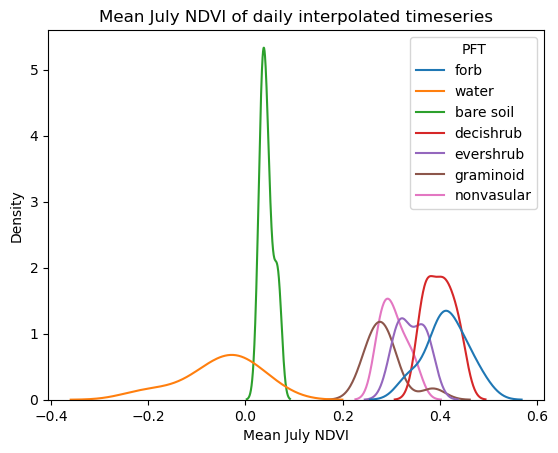

In [20]:
sns.kdeplot(x=pftmeanjuly['Mean July NDVI'], 
            hue=pftmeanjuly['PFT']).set(title='Mean July NDVI of daily interpolated timeseries')

In [21]:
# Set the percentage of amplitude for the estimation of the threshold
# th = 0.2 # advice 0.2-0.8
# # Set the minimum NDVI value for the reclassification of non-vegetated
# threshMin = 0.3 * 10000

In [22]:
# threshMin

In [23]:
# find min, max, amplitude
# test3 = test2.copy()
# test3['max_value'] = test3.max(axis=1)
# test3['amplitude'] = test3['max_value'] - threshMin
# test3['thresh'] = test3['amplitude'] * th + (threshMin)

In [24]:
# test3

In [25]:
# select ndvi interp values above threshold
# def change_to_null(row, cols):
#     new_df = []
#     for column in cols:
#         new_row = row[column]
#         if row[column] < row['thresh']:
#             row[column] = np.nan
#             new_row = row[column]
#         new_df.append(new_row)
#     return new_df

# cols = test3.columns.tolist()
# land_rows = test3.apply(lambda row: change_to_null(row, cols),
#                         axis=1, result_type='expand')

In [26]:
#land_rows.columns = test3.columns.tolist()

# 3. Inflection point method

## 3.1. limit timeseries to Apr-Nov

In [27]:
aprnov_2019spline = select_period(splined_2019, "2019-04-01", "2019-10-31")
aprnov_2019spline

timestamp,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06,2019-04-07,2019-04-08,2019-04-09,2019-04-10,...,2019-10-22,2019-10-23,2019-10-24,2019-10-25,2019-10-26,2019-10-27,2019-10-28,2019-10-29,2019-10-30,2019-10-31
0,-0.240158,-0.239587,-0.238926,-0.238164,-0.237292,-0.236298,-0.235173,-0.233906,-0.232488,-0.230906,...,-0.081423,-0.083301,-0.085172,-0.087036,-0.088891,-0.090739,-0.092579,-0.094411,-0.096235,-0.098051
1,-0.273980,-0.272638,-0.271020,-0.269129,-0.266967,-0.264539,-0.261846,-0.258892,-0.255679,-0.252209,...,-0.126137,-0.128523,-0.130876,-0.133198,-0.135487,-0.137745,-0.139971,-0.142167,-0.144333,-0.146469
2,-0.272695,-0.272101,-0.271239,-0.270110,-0.268714,-0.267055,-0.265132,-0.262948,-0.260503,-0.257800,...,-0.097569,-0.100197,-0.102795,-0.105365,-0.107907,-0.110421,-0.112908,-0.115368,-0.117800,-0.120206
3,-0.273498,-0.272801,-0.271845,-0.270631,-0.269161,-0.267435,-0.265457,-0.263226,-0.260745,-0.258015,...,-0.080407,-0.083205,-0.085976,-0.088719,-0.091435,-0.094124,-0.096786,-0.099421,-0.102031,-0.104614
4,-0.205617,-0.205307,-0.204970,-0.204591,-0.204159,-0.203661,-0.203084,-0.202416,-0.201643,-0.200753,...,-0.084853,-0.086388,-0.087916,-0.089437,-0.090951,-0.092458,-0.093957,-0.095450,-0.096935,-0.098413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,-0.176695,-0.176437,-0.175998,-0.175374,-0.174567,-0.173575,-0.172398,-0.171034,-0.169484,-0.167746,...,-0.091261,-0.092239,-0.093204,-0.094158,-0.095100,-0.096030,-0.096948,-0.097855,-0.098751,-0.099635
90,-0.216404,-0.216601,-0.216526,-0.216182,-0.215574,-0.214706,-0.213583,-0.212208,-0.210585,-0.208720,...,-0.118251,-0.119663,-0.121041,-0.122384,-0.123693,-0.124968,-0.126210,-0.127420,-0.128597,-0.129742
91,-0.223143,-0.223232,-0.223030,-0.222541,-0.221771,-0.220726,-0.219411,-0.217831,-0.215993,-0.213902,...,-0.121691,-0.123154,-0.124578,-0.125966,-0.127317,-0.128632,-0.129911,-0.131155,-0.132364,-0.133540
92,-0.246353,-0.246323,-0.245897,-0.245087,-0.243901,-0.242351,-0.240446,-0.238197,-0.235614,-0.232706,...,-0.119622,-0.121413,-0.123169,-0.124892,-0.126582,-0.128239,-0.129863,-0.131454,-0.133014,-0.134543


In [28]:
# get inflection points
def second_derivative(row):
    # compute first then second derivative
    deriv2 = np.gradient(np.gradient(row))
    #deriv2 = np.gradient(row)
    return deriv2

In [29]:
smooth_d2 = aprnov_2019spline.apply(second_derivative)

[50, 76, 68, 89, 60, 1, 64, 38, 36, 10]
[  9  79 130 166]


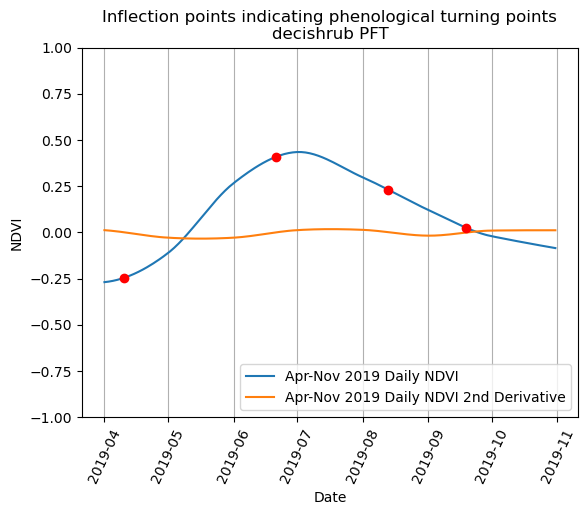

[ 34 115]


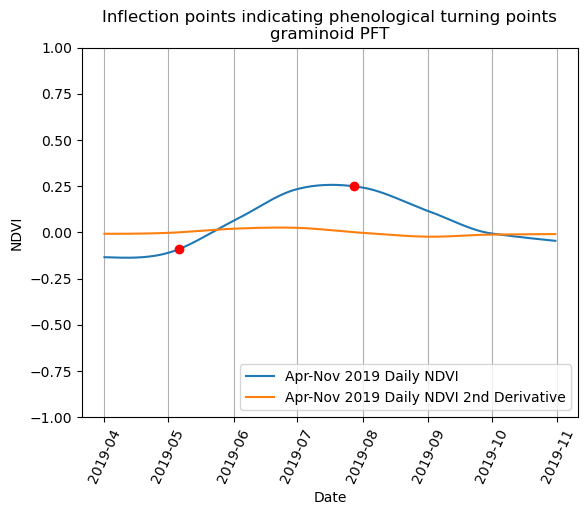

[ 67 112 127]


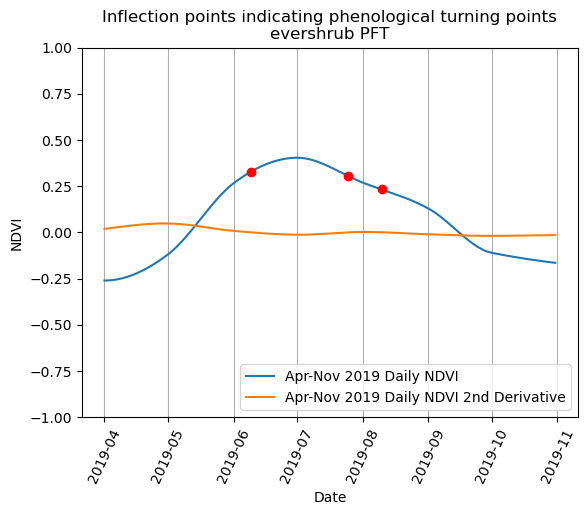

[ 94 172]


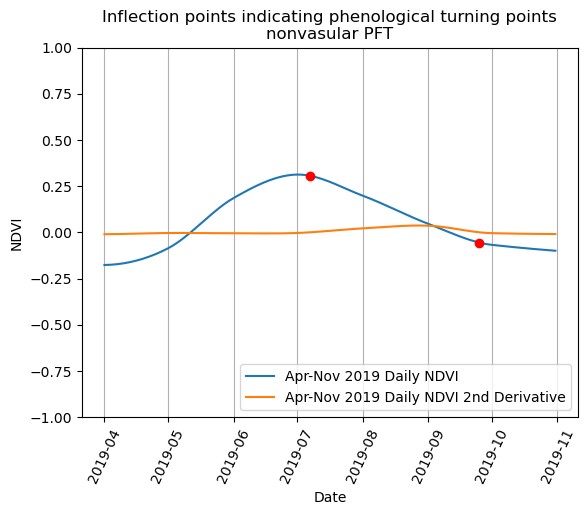

[ 85 172]


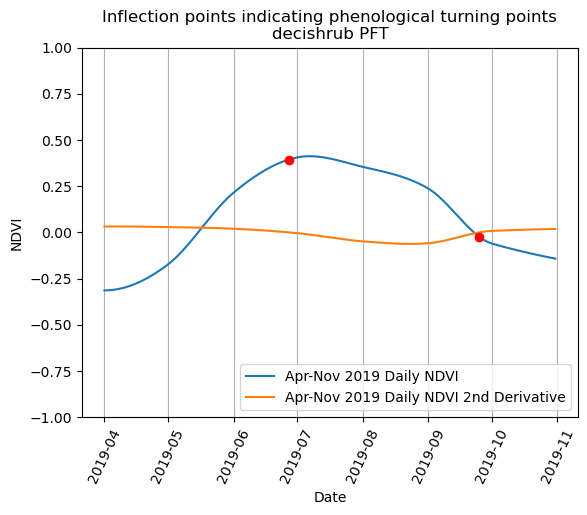

[ 16  74  98 166]


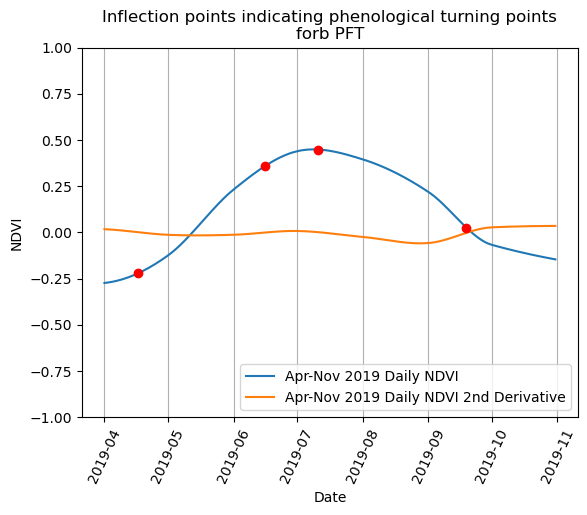

[63]


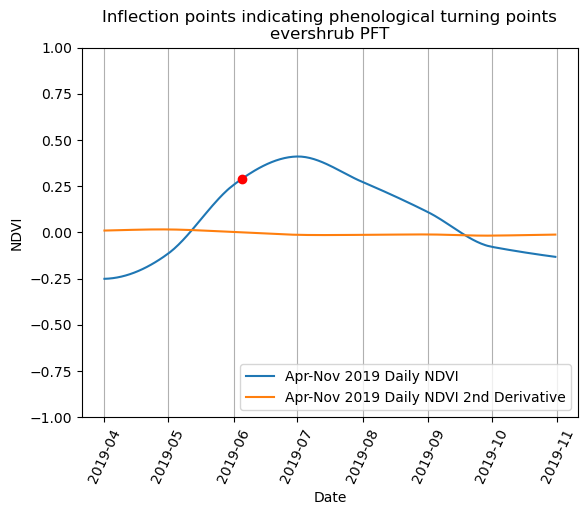

[ 28  36 100 167]


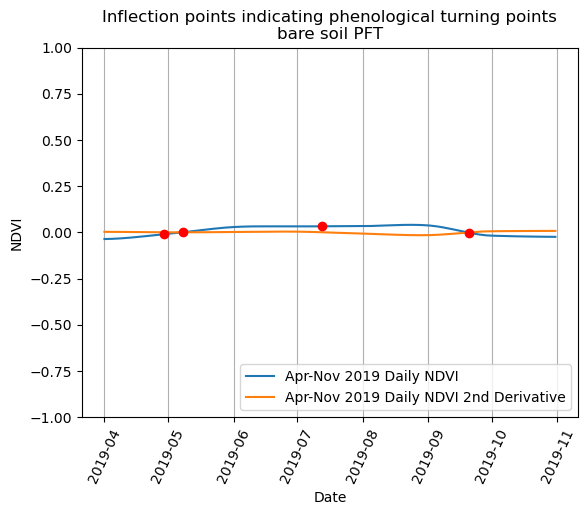

[ 48 110 163]


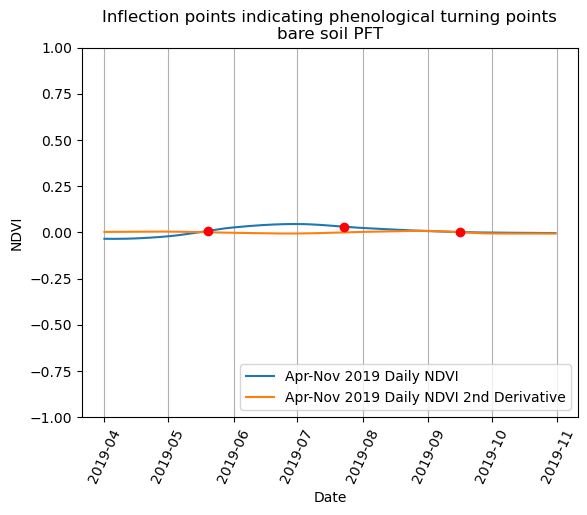

[ 45 195]


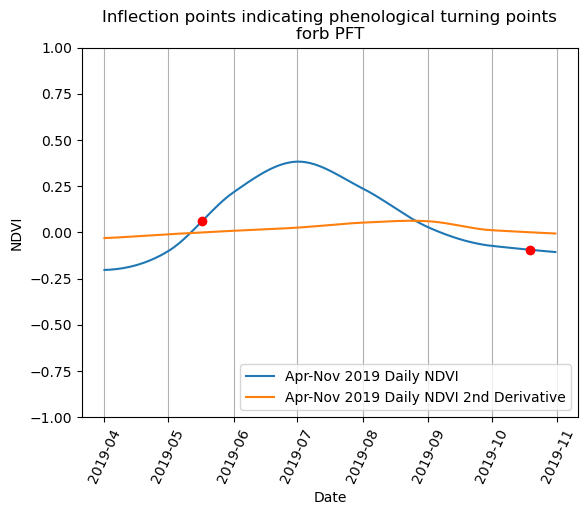

In [31]:
# # plot results
import random
res = random.sample(range(1, len(smooth_d2)-1), 10)
res = [50, 76, 68, 89, 60, 1, 64, 38, 36, 10]
print(res)
for r in res:
    
    functype = pft.iloc[r].tolist()[0]
    
    x = aprnov_2019spline.columns.tolist()
    f = aprnov_2019spline.iloc[r]
    g = smooth_d2.iloc[r]

    plt.plot(x, f, '-', label='Apr-Nov 2019 Daily NDVI')
    plt.plot(x, g, '-', label='Apr-Nov 2019 Daily NDVI 2nd Derivative')
    
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.title(f'Inflection points indicating phenological turning points\n{functype} PFT')
    plt.legend(loc='lower right')
    plt.ylim(-1, 1)
    plt.grid(visible=True, which='major', axis='x')

    idx = np.argwhere(np.diff(np.sign(g))).flatten()
    print(idx)
    for i in range(len(idx)):
        plt.plot(x[idx[i]], f[idx[i]], 'ro')
    plt.xticks(rotation=65)
    plt.show()

# 4. Decile method

In [48]:
# calculate percentiles
percentiles = np.arange(.10,1.01,.10)
aprnov_2019spline_pc = aprnov_2019spline.quantile(percentiles, 
                                                  interpolation='nearest', 
                                                  method='single', 
                                                  axis=1).T
aprnov_2019spline_pc.columns = [str(round(val, 1)) for val in percentiles]
aprnov_2019spline_pc

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,-0.195507,-0.087036,-0.052311,-0.006937,0.063395,0.166081,0.276815,0.373416,0.440146,0.473920
1,-0.191645,-0.121265,-0.077153,0.017431,0.144525,0.249995,0.328697,0.387480,0.430506,0.448768
2,-0.205684,-0.102795,-0.054544,0.026259,0.148011,0.254731,0.321102,0.369975,0.406595,0.423487
3,-0.206335,-0.090177,-0.041378,0.038301,0.157239,0.254969,0.327697,0.374921,0.407845,0.420486
4,-0.176314,-0.089437,-0.060965,-0.022069,0.042503,0.139270,0.248289,0.338189,0.404894,0.434929
...,...,...,...,...,...,...,...,...,...,...
89,-0.132011,-0.088256,-0.067779,-0.018311,0.045776,0.114452,0.184915,0.241507,0.289672,0.312580
90,-0.168910,-0.115318,-0.084967,-0.003608,0.106199,0.186784,0.240070,0.269291,0.293301,0.303668
91,-0.171037,-0.118651,-0.086042,-0.000331,0.107763,0.194729,0.248740,0.277190,0.298860,0.307408
92,-0.176237,-0.114783,-0.078566,0.017426,0.137810,0.224682,0.250940,0.273741,0.301381,0.315748


In [49]:
# find index at each percentile
orig = aprnov_2019spline.to_numpy()
orig_p = aprnov_2019spline_pc.to_numpy()
idxs = []
for row, rowp in zip(orig, orig_p):
    sort_idx = row.argsort()
    out = sort_idx[np.searchsorted(row,rowp,sorter = sort_idx)]
    idxs.append(out)

[50, 76, 68, 89, 60, 1, 64, 38, 36, 10]


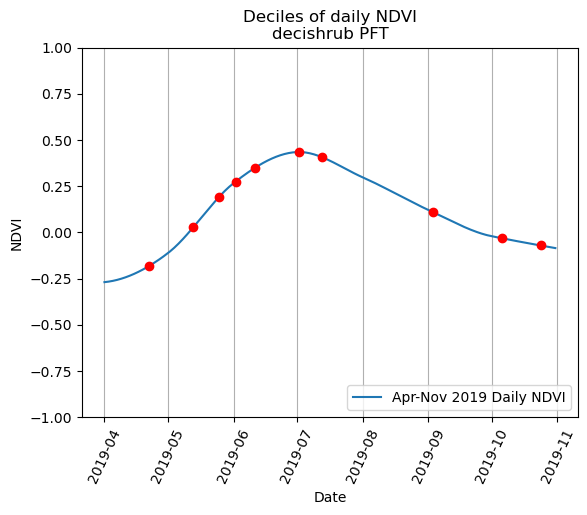

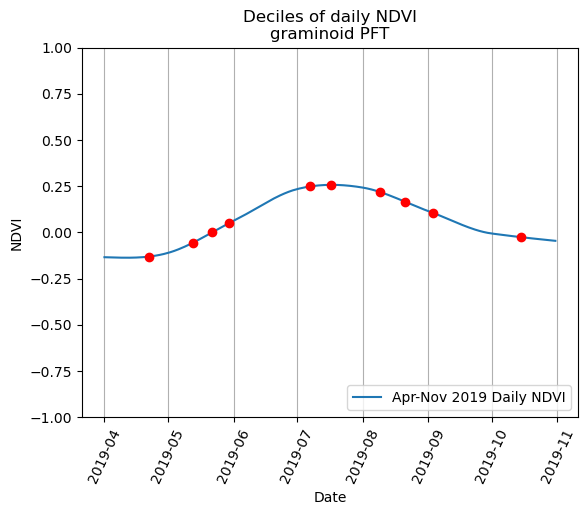

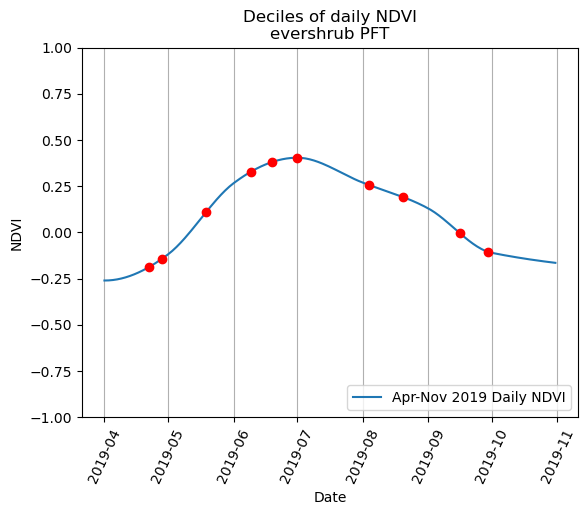

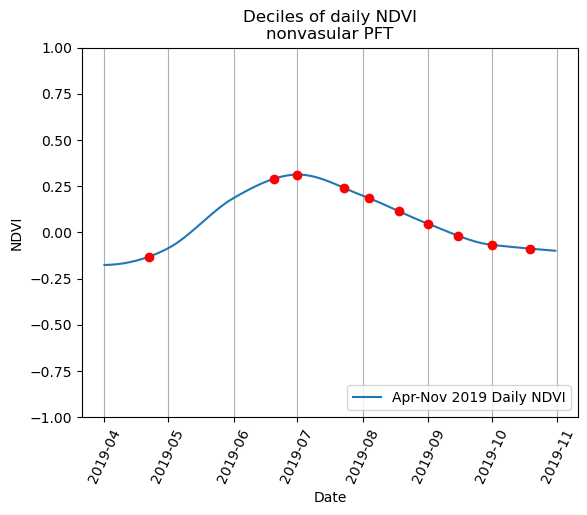

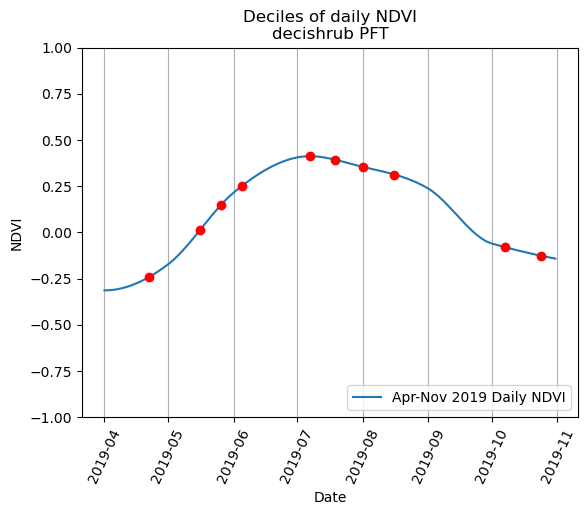

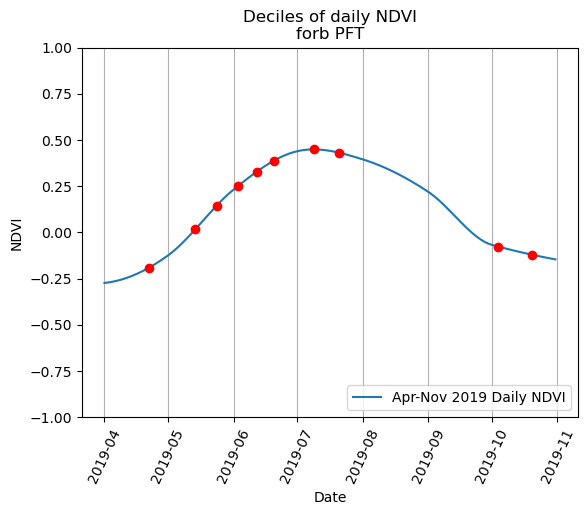

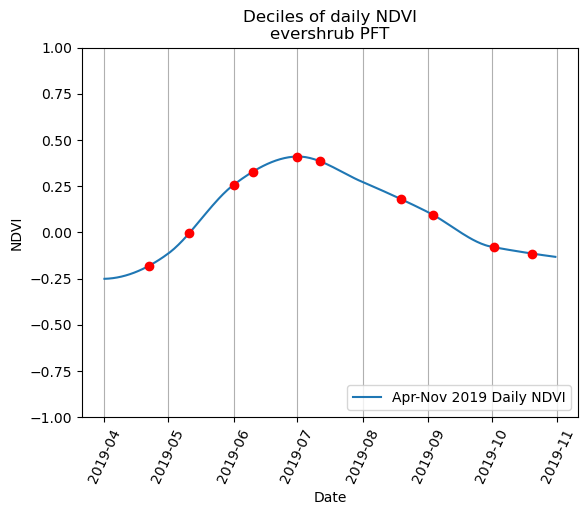

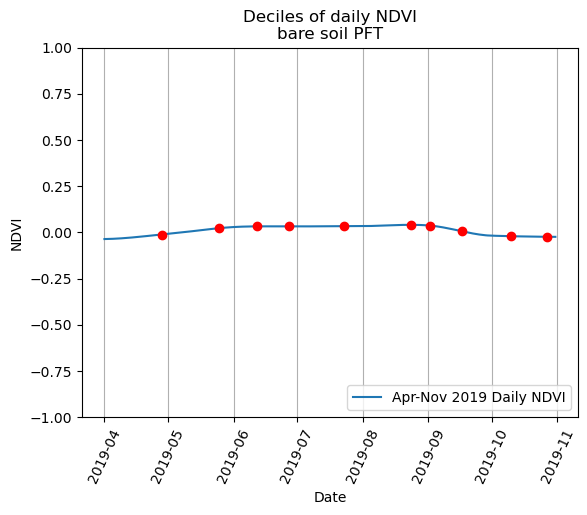

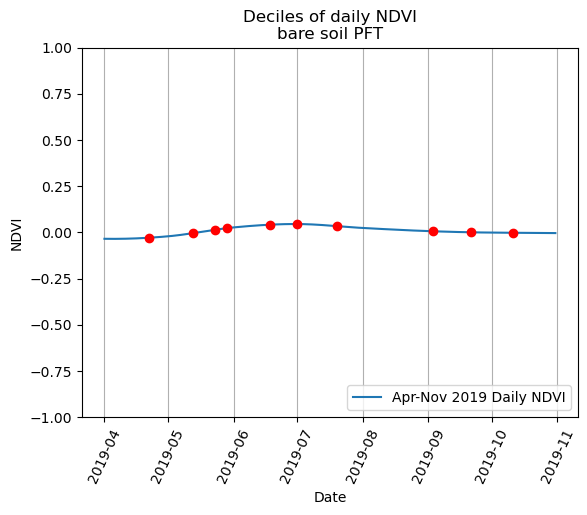

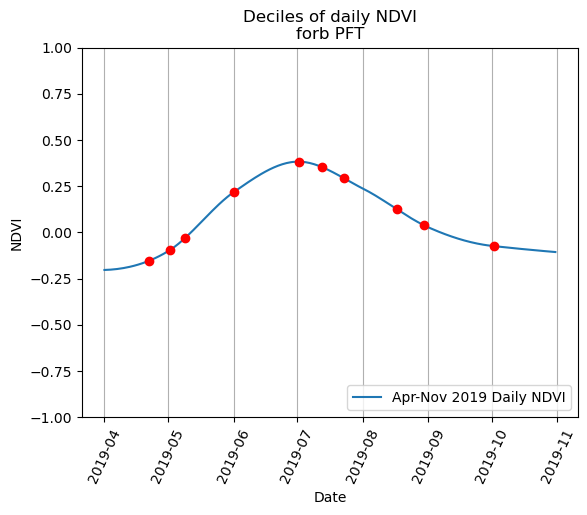

In [50]:
# plot results
res = random.sample(range(1, len(aprnov_2019spline)-1), 10)
res = [50, 76, 68, 89, 60, 1, 64, 38, 36, 10]
print(res)

for r in res:
    
    functype = pft.iloc[r].tolist()[0]
    
    x = aprnov_2019spline.columns.tolist()
    y = aprnov_2019spline.iloc[r]
    x1 = aprnov_2019spline.iloc[r, idxs[r]].index.tolist()
    y1 = aprnov_2019spline.iloc[r, idxs[r]]

    plt.plot(x, y, '-', label='Apr-Nov 2019 Daily NDVI')
    plt.plot(x1, y1, 'ro')
    
    plt.grid(visible=True, which='major', axis='x')
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.title(f'Deciles of daily NDVI\n{functype} PFT')
    plt.legend(loc='lower right')
    plt.ylim(-1, 1)
    plt.xticks(rotation=65)
    plt.show()

In [51]:
# extra decile-based phenometrics
stats = aprnov_2019spline.agg(['min', 'max', 'median', 
                               'mean', 'skew', 'std', 
                               'kurtosis'],
                              axis=1)
final = pd.concat([aprnov_2019spline_pc, stats], axis=1)
final

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,min,max,median,mean,skew,std,kurtosis
0,-0.195507,-0.087036,-0.052311,-0.006937,0.063395,0.166081,0.276815,0.373416,0.440146,0.473920,-0.240158,0.473920,0.063156,0.109915,0.178449,0.226930,-1.285581
1,-0.191645,-0.121265,-0.077153,0.017431,0.144525,0.249995,0.328697,0.387480,0.430506,0.448768,-0.273980,0.448768,0.142689,0.125961,-0.108481,0.238573,-1.465808
2,-0.205684,-0.102795,-0.054544,0.026259,0.148011,0.254731,0.321102,0.369975,0.406595,0.423487,-0.272695,0.423487,0.147491,0.123996,-0.201766,0.229132,-1.392386
3,-0.206335,-0.090177,-0.041378,0.038301,0.157239,0.254969,0.327697,0.374921,0.407845,0.420486,-0.273498,0.420486,0.152758,0.129391,-0.239937,0.227862,-1.347058
4,-0.176314,-0.089437,-0.060965,-0.022069,0.042503,0.139270,0.248289,0.338189,0.404894,0.434929,-0.205617,0.434929,0.039733,0.094080,0.268453,0.208331,-1.312279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,-0.132011,-0.088256,-0.067779,-0.018311,0.045776,0.114452,0.184915,0.241507,0.289672,0.312580,-0.176695,0.312580,0.043918,0.063895,0.154142,0.157368,-1.380290
90,-0.168910,-0.115318,-0.084967,-0.003608,0.106199,0.186784,0.240070,0.269291,0.293301,0.303668,-0.216601,0.303668,0.101665,0.076328,-0.174733,0.180506,-1.544543
91,-0.171037,-0.118651,-0.086042,-0.000331,0.107763,0.194729,0.248740,0.277190,0.298860,0.307408,-0.223232,0.307408,0.106840,0.079302,-0.188894,0.184880,-1.548377
92,-0.176237,-0.114783,-0.078566,0.017426,0.137810,0.224682,0.250940,0.273741,0.301381,0.315748,-0.246353,0.315748,0.135615,0.086505,-0.309594,0.188692,-1.455608


In [ ]:
name = 'harmonicFitted_decile_phenology_purePFT.csv'

# 5. TIMESAT phenometrics method

https://github.com/lewistrotter/PhenoloPy/tree/main
- POS: (peak) Maximum value in a timeseries.
- MOS: (middle) Mean value and time where the left and right slope edges have increased and decreased to the 80% level of the season, respectively.
- VOS: (valley) Minimum value in a timeseries.
- BSE: (base) Mean value of the lowest vegetation values to the left and right of Peak of Season.
- SOS: (start) Six methods available: 1) seasonal amplitude; 2) absolute amplitude; 3) Relative amplitude; 4) LOESS STL Trend line; 5) First value of positive slope; and 6) Median value of positive slope.
- EOS: (end) Six methods available: 1) seasonal amplitude; 2) absolute amplitude; 3) Relative amplitude; 4) LOESS STL Trend line; 5) First value of negative slope; and 6) Median value of negative slope.
- LOS: (length) The day of year at SOS minus EOS.
- ROI: (greenup) Calculated as the ratio of the difference between the left 20% and 80% levels and the corresponding time difference.
- ROD: (greendown) Calculated as the ratio of the difference between the right 20% and 80% levels and the corresponding time difference.
- AOS: (amplitude) The difference between the maximum value and the VOS/BSE value.
- SIOS: (short integral) Calculated using the trapezoidal rule on the total vegetation values between season start and end minus the VOS/BSE level value.
- LIOS: (long integral) Calculated using the trapezoidal rule between the total vegetation values between season start and end.
- SIOT: (short integral) Calculated using the trapezoidal rule on the total vegetation values minus the VOS/BSE level value.
- LIOT: (long integral) Calculated using the trapezoidal rule between the total vegetation values between season start and end.
- NOS: (num seasons) Peaks detected using scipy find_peaks and any peaks are over 3 months apart.